In [1]:
import numpy as np
import pyfftw
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import multiprocessing
import MatMult as MM

In [2]:
def Gaussian(z,z0,a,q0):
    return np.exp(-((z-z0)**2)/(2*a**2))*np.exp(1j*q0*z)

def Gaussian2D(x,x0,z,z0,a,p0,q0):
    return np.exp(-((x-x0)**2+(z-z0)**2)/(2*a**2))*np.exp(1j*q0*z)*np.exp(1j*p0*x)


def Ev_momentum(p,q,t):
    m = 1
    Hq = q**2/(2*m)
    Hp = p**2/(2*m)
    return np.exp(-1j*Hq*t)*np.exp(-1j*Hp*t)

In [3]:
Nx = 2**12
Nz = 2**12
z,dz = np.linspace(-10,10,Nz,retstep=True)
x,dx = np.linspace(-10,10,Nx,retstep=True)

grid = np.meshgrid(x,z)
z0 = 0.0
x0 = 0.0
q0 = -10
p0 = -6.0
a = 1.0

WavePacket = Gaussian2D(grid[0],x0,grid[1],z0,a,p0,q0)

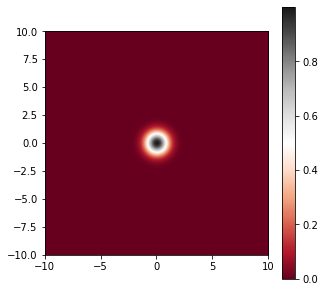

In [4]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
# ax.plot(z,np.abs(WavePacket)**2)
# ax.contourf(grid[0],grid[1],np.abs(WavePacket)**2)
plot = ax.imshow(np.abs(WavePacket)**2,origin='lower',cmap='RdGy',extent=[x[0],x[-1],z[0],z[-1]])
fig.colorbar(plot)

In [5]:
# %%timeit
# FFTWavePacket = scp.fft.fft2(WavePacket)/(Nx*Nz)
# FFTWavePacketOrdered = scp.fft.fftshift(FFTWavePacket)

inputForward = pyfftw.empty_aligned((Nx, Nz), dtype='complex128')
outputForward = pyfftw.empty_aligned((Nx, Nz), dtype='complex128')
fft_objectForward = pyfftw.FFTW(inputForward, outputForward,axes=(0,1),threads=multiprocessing.cpu_count())

inputBackward= pyfftw.empty_aligned((Nx, Nz), dtype='complex128')
outputBackward = pyfftw.empty_aligned((Nx, Nz), dtype='complex128')
fft_objectBackward = pyfftw.FFTW(inputBackward, outputBackward,axes=(1,0),direction='FFTW_BACKWARD',threads=multiprocessing.cpu_count())


In [7]:
# %%timeit

inputForward = WavePacket

FFTWavePacket = fft_objectForward(inputForward);
FFTWavePacketOrdered = scp.fft.fftshift(FFTWavePacket,axes=(0,1))

        
dq = 2*np.pi/(Nz*dz);
q = np.linspace(int(-Nz/2),int(Nz/2),Nz)*dq
dp = 2*np.pi/(Nx*dx);
p = np.linspace(int(-Nx/2),int(Nx/2),Nx)*dp

momentum_grid = np.meshgrid(p,q)
# FutureFFTWavePacket = Ev_momentum(momentum_grid[0],momentum_grid[1],0.7)*FFTWavePacketOrdered

FutureFFTWavePacket = MM.MatrixMult(Ev_momentum(momentum_grid[0],momentum_grid[1],0.7),FFTWavePacketOrdered,Nx)


(-20.0, 20.0)

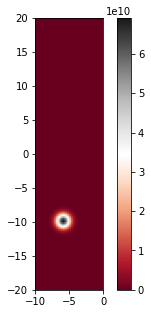

In [8]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
# ax.contourf(momentum_grid[0],momentum_grid[1],np.abs(FFTWavePacketOrdered)**2)
plot = ax.imshow(np.abs(FFTWavePacketOrdered)**2,origin='lower',cmap='RdGy',extent=[p[0],p[-1],q[0],q[-1]])
fig.colorbar(plot)
ax.set_xlim(-10,0)
ax.set_ylim(-20,20)

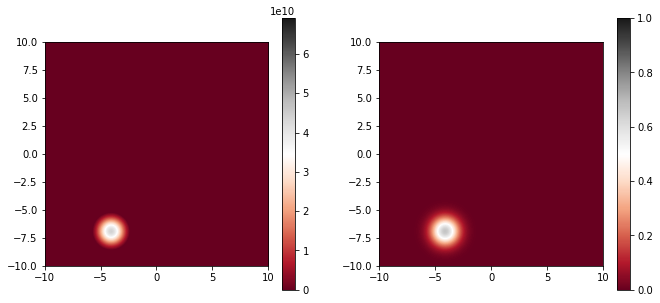

In [9]:
# IFFTWavePacket = scp.fft.ifft2(FFTWavePacketOrdered)*(Nx*Nz)
# FutureIFFTWavePacket = scp.fft.ifft2(FutureFFTWavePacket)*(Nx*Nz)
# IFFTWavePacket = scp.fft.fftshift(IFFTWavePacket)

inputBackward = FFTWavePacket
IFFTWavePacket = fft_objectBackward(inputBackward);
# IFFTWavePacketOrdered = scp.fft.fftshift(IFFTWavePacket,axes=(0,1))

inputBackward = FutureFFTWavePacket
FutureIFFTWavePacket = fft_objectBackward(inputBackward);
# # FutureIFFTWavePacketOrdered = scp.fft.fftshift(FutureIFFTWavePacket,axes=(0,1))


# dx = 2*np.pi/(N*dk);
# x = np.linspace(int(-N/2),int(N/2),N)*dx

fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
# ax.contourf(grid[0],grid[1],np.abs(IFFTWavePacket)**2,cmap='RdGy')
ax.imshow(np.abs(IFFTWavePacket)**2,origin='lower',cmap='RdGy',extent=[x[0],x[-1],z[0],z[-1]],vmin=0.1, vmax=1.)
fig.colorbar(plot)
# # ax.contourf(grid[0],grid[1],np.abs(FutureIFFTWavePacket)**2)

ax = fig.add_subplot(122)
plot = ax.imshow(np.abs(FutureIFFTWavePacket)**2,origin='lower',cmap='RdGy',extent=[x[0],x[-1],z[0],z[-1]], vmin=0.0, vmax=1.)
fig.colorbar(plot)
# ax.imshow(np.abs(FutureIFFTWavePacket)**2,extent=[x[0],x[-1],z[0],z[-1]])

In [ ]:
multiprocessing.cpu_count()